<h1 style="font-size:2.0em; font-weight:bold; text-align:center;">Model Training </h1>

This project is a **Proof of Concept (PoC)** aimed at detecting potential financial crime in corporate banking transactions. It reflects my growing interest in financial crime prevention, particularly in the context of evolving geopolitical risks.

The dataset spans from **April 2, 2025** to **July 2, 2025**, based on the assumption that in mid-2025, trade tensions lead to increased abnormal or suspicious transaction activities.

- Model Training: Isolation Forest  
- Evaluation: Precision-Recall, ROC-AUC, confusion matrix, feature importance  

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
%matplotlib inline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures,MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data/CLEAN_nordic_transactions_with_fraud.csv')
data.head().T

,0,1,2,3,4
currency_DKK,0.0,0.0,0.0,1.0,0.0
currency_EUR,0.0,0.0,0.0,0.0,0.0
currency_NOK,1.0,0.0,1.0,0.0,1.0
currency_SEK,0.0,1.0,0.0,0.0,0.0
currency_USD,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
is_sequential,0.0,0.0,0.0,0.0,0.0
is_repeated_amount,0.0,0.0,0.0,0.0,0.0
is_high_frequency,0.0,0.0,0.0,1.0,0.0
is_split,0.0,0.0,0.0,1.0,0.0


**The correlations between the dependent variables.**

Create a histogram of the correlation values and identify those that are most correlated (either positively or negatively).

In [3]:
feature_cols = data.columns.drop('is_fraud')
corr_values = data[feature_cols].corr()

tril_index = np.tril_indices_from(corr_values)

for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.nan
    
# Stack the data and convert to a data frame
corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

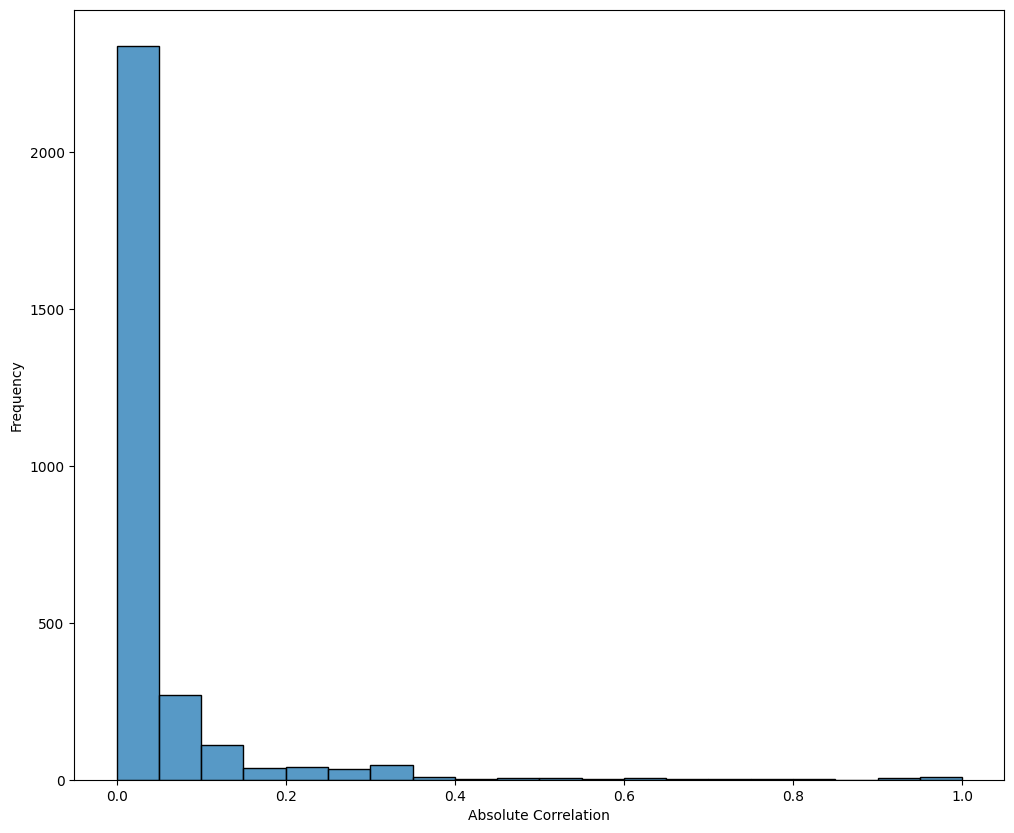

In [4]:
plt.figure(figsize=(12,10))
sns.histplot(corr_values['abs_correlation'], bins=20)
plt.xlabel('Absolute Correlation')
plt.ylabel('Frequency')
plt.show()

In [5]:
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
2882,booking_month,value_month,0.985349,0.985349
2861,transaction_month,booking_month,0.983254,0.983254
2863,transaction_month,value_month,0.968637,0.968637
48,currency_DKK,from_account_country_DK,0.963321,0.963321
2899,value_month,payment_month,0.957749,0.957749
199,currency_NOK,from_account_country_NO,0.950904,0.950904
124,currency_EUR,from_account_country_FI,0.947619,0.947619
273,currency_SEK,from_account_country_SE,0.946090,0.946090
2884,booking_month,payment_month,0.943111,0.943111
2865,transaction_month,payment_month,0.926452,0.926452


when we see something that's so highly correlated, we may want to do feature selection.

In [6]:
data_corr = data.corr()
data_corr.sort_values('is_fraud', ascending=False).query('is_fraud>0.2')

,currency_DKK,currency_EUR,currency_NOK,currency_SEK,currency_USD,from_account_name_rare_var,counterparty_name_0,counterparty_name_rare_var,counterparty_country_CN,counterparty_country_DE,...,value_month,payment_day,payment_day_of_week,payment_month,is_rirsk _country,is_sequential,is_repeated_amount,is_high_frequency,is_split,is_fraud
is_fraud,-0.095821,0.017586,-0.096914,0.028103,0.304783,NaN,-0.037852,0.037852,0.038948,-0.061623,...,0.012039,0.022712,NaN,0.010434,0.268610,-0.002714,-0.002458,0.009489,0.007825,1.000000
narrative_Invoice for electronic parts,-0.087250,0.037432,-0.088245,0.048807,0.182834,NaN,-0.034466,0.034466,0.046185,-0.056111,...,0.008043,0.008832,NaN,0.005309,0.244584,0.000496,-0.002238,0.015932,0.013896,0.910555
turnover_jump_pct,-0.135274,0.308225,-0.153870,-0.147116,0.259344,NaN,-0.027095,0.027095,0.028670,-0.044188,...,0.001485,-0.000139,NaN,-0.005486,0.169498,0.011195,0.009418,-0.001384,0.002320,0.540379
counterparty_country_RU,-0.068373,-0.024699,-0.069152,-0.031583,0.405985,NaN,-0.027009,0.027009,-0.050222,-0.043971,...,0.001321,0.028401,NaN,-0.000018,0.191665,0.011509,-0.001754,0.000068,0.001460,0.371962
counterparty_country_SG,-0.066558,-0.029236,-0.067317,-0.026739,0.397759,NaN,-0.026292,0.026292,-0.048889,-0.042804,...,-0.013082,0.020983,NaN,-0.010836,0.186579,0.016886,0.115803,-0.000117,0.001746,0.353733
currency_USD,-0.116186,-0.121287,-0.117510,-0.120513,1.000000,NaN,-0.045896,0.045896,0.097510,-0.074719,...,0.000619,0.044948,NaN,0.000422,0.325697,0.001477,0.066339,0.002374,0.002845,0.304783
payment_purpose_code_Goods,-0.060390,-0.023734,-0.066720,-0.021087,0.360033,NaN,-0.019250,0.019250,0.027272,-0.044558,...,-0.005905,0.027956,NaN,-0.004298,0.162800,-0.005455,0.023884,0.000744,-0.002684,0.296928
transaction_type_description_Wire Transfer,-0.063397,-0.035087,-0.058960,0.000671,0.328101,NaN,-0.016150,0.016150,0.034732,-0.027138,...,0.006889,0.009171,NaN,0.007612,0.148765,-0.000216,0.021766,0.007160,-0.003022,0.270593
is_rirsk _country,-0.057134,-0.027781,-0.056891,-0.013710,0.325697,NaN,-0.022780,0.022780,0.618598,-0.229413,...,0.007576,0.021212,NaN,0.006975,1.000000,-0.013240,0.021606,-0.009471,-0.016982,0.268610
swift_message_type_MT103,-0.044928,-0.014022,-0.053475,-0.018849,0.274845,NaN,-0.021701,0.021701,0.043505,-0.028676,...,0.006371,0.013404,NaN,0.005926,0.125797,0.012554,0.018233,0.006067,0.005159,0.226672


## <h2 style="font-size: 1.8em; font-weight: bold;"> Baseline Model Training </h2>

**Train-Test Split**

As `is_fraud` is imbalanced, so we use `StratifiedShuffleSplit()` to maintain the same ratio of predictor classes.

In [7]:
X = data.drop('is_fraud', axis=1)
y = data['is_fraud']

strat_shuf_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_idx, test_idx in strat_shuf_split.split(X, y):
  X_train = data.loc[train_idx, feature_cols]
  y_train = data.loc[train_idx, 'is_fraud']

  X_test  = data.loc[test_idx, feature_cols]
  y_test  = data.loc[test_idx, 'is_fraud']

Let's check if the train and test sets have the same class ratio for fraud and non-fraud cases.

In [8]:
y_train.value_counts(normalize=True) 

is_fraud
0    0.970343
1    0.029657
Name: proportion, dtype: float64

In [9]:
y_test.value_counts(normalize=True)

is_fraud
0    0.970346
1    0.029654
Name: proportion, dtype: float64

In [10]:
#Fit Baseline Model
lr = LogisticRegression(max_iter=1000, random_state=42).fit(X_train, y_train)
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)
iso_f = IsolationForest(random_state=42).fit(X_train)

#Predict
y_test_pre_lr = lr.predict(X_test)
y_test_pre_rl= rf.predict(X_test)
y_test_pre_iso_f= iso_f.predict(X_test) 

y_train_pre_lr = lr.predict(X_train)
y_train_pre_rl= rf.predict(X_train)
y_train_pre_iso_f= iso_f.predict(X_train) 


=== Logistic Regression ===
Accuracy: 0.9953871499176277
Accuracy: 0.9953871499176277
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2945
           1       0.99      0.86      0.92        90

    accuracy                           1.00      3035
   macro avg       0.99      0.93      0.96      3035
weighted avg       1.00      1.00      1.00      3035



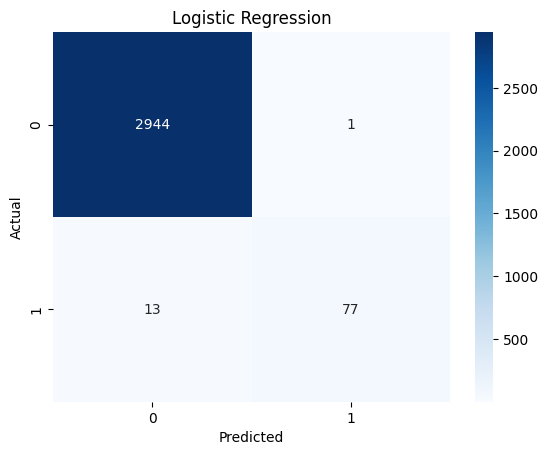

=== Random Forest  ===
Accuracy: 0.9993410214168039
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2945
           1       0.99      0.99      0.99        90

    accuracy                           1.00      3035
   macro avg       0.99      0.99      0.99      3035
weighted avg       1.00      1.00      1.00      3035



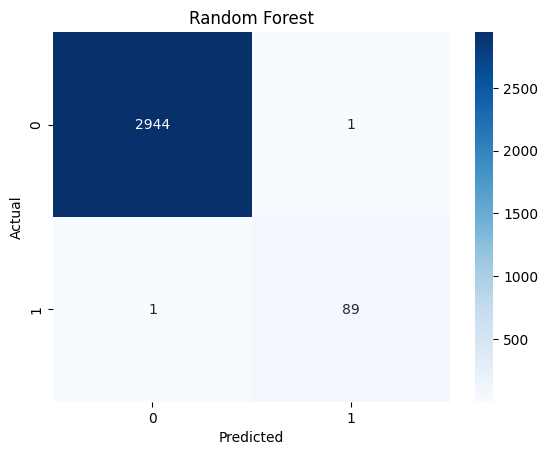

=== Isolation Forest ===
Accuracy: 0.5960461285008237
              precision    recall  f1-score   support

           0       1.00      0.59      0.74      2945
           1       0.06      0.92      0.12        90

    accuracy                           0.60      3035
   macro avg       0.53      0.75      0.43      3035
weighted avg       0.97      0.60      0.72      3035



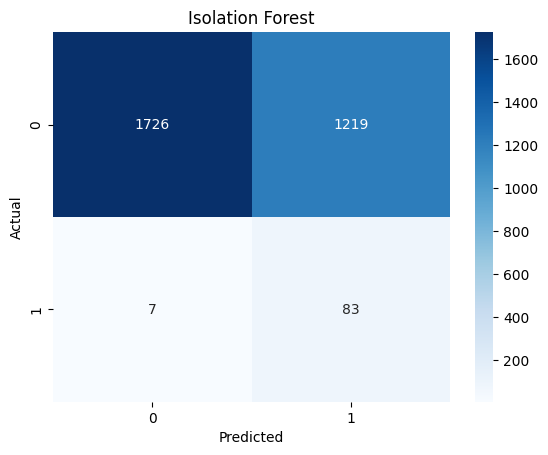

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

print("=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_test_pre_lr))
print("Accuracy:", accuracy_score(y_test, y_test_pre_lr))
print(classification_report(y_test, y_test_pre_lr))
plot_conf_matrix(y_test, y_test_pre_lr, "Logistic Regression")


print("=== Random Forest  ===")
print("Accuracy:", accuracy_score(y_test, y_test_pre_rl))
print(classification_report(y_test, y_test_pre_rl))
plot_conf_matrix(y_test, y_test_pre_rl, "Random Forest")

# Convert to binary: 1 → 0 (normal), -1 → 1 (anomaly)
y_pred_iso_binary = [0 if x == 1 else 1 for x in y_test_pre_iso_f]
print("=== Isolation Forest ===")
print("Accuracy:", accuracy_score(y_test, y_pred_iso_binary))
print(classification_report(y_test, y_pred_iso_binary))
plot_conf_matrix(y_test, y_pred_iso_binary, "Isolation Forest")


In [12]:
logreg_coefs = pd.DataFrame({
    'Feature': X_train.columns,
    'Value': lr.coef_[0],
    'Model': 'Logistic Regression'
})

rf_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Value': rf.feature_importances_,
    'Model': 'Random Forest'
})

try:
    iso_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Value': iso_f.feature_importances_,  # available in sklearn 1.1+
        'Model': 'Isolation Forest'
    })
except AttributeError:
    iso_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Value': [0]*len(X_train.columns),
        'Model': 'Isolation Forest (no feature_importances_)'
    })

In [13]:
rf_importance.sort_values('Value',ascending=False).query('Value > 0.1')

,Feature,Value,Model
28,narrative_Invoice for electronic parts,0.23431,Random Forest
61,expected_turnover,0.12005,Random Forest


In [14]:
X_train_reset = X_train.reset_index(drop=True)
X_test_reset = X_test.reset_index(drop=True)

# Merge on all columns to find exact duplicate rows
overlap = pd.merge(X_train_reset, X_test_reset, how='inner')

print(f"Number of overlapping samples between train and test: {len(overlap)}")

Number of overlapping samples between train and test: 0
